# MAT 388E Project 
**Engin Pehlivan 090200769**  
**Ozan Yeşil 090190325**  
**Abdulsamet Balveren 090190751**

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
import os
import warnings
warnings.filterwarnings("ignore")
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile
import scipy.cluster.hierarchy as hc

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RNN, Dropout, SimpleRNN
from keras.callbacks import EarlyStopping

# Importing data from Kaggle

In [2]:
os.environ['KAGGLE_USERNAME'] = "enginpehlivan"
os.environ['KAGGLE_KEY'] = "4604d450a00ab80b63c5a2c11df012fb"
api = KaggleApi()
api.authenticate()

In [3]:
api.competition_download_file('store-sales-time-series-forecasting',
                              'train.csv', path='./')
api.competition_download_file('store-sales-time-series-forecasting',
                              'test.csv', path='./')
api.competition_download_file('store-sales-time-series-forecasting',
                              'transactions.csv', path='./')
api.competition_download_file('store-sales-time-series-forecasting',
                              'stores.csv', path='./')
api.competition_download_file('store-sales-time-series-forecasting',
                              'holidays_events.csv', path='./')
api.competition_download_file('store-sales-time-series-forecasting',
                              'oil.csv', path='./')

train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
transactions.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
stores.csv: Skipping, found more recently modified local copy (use --force to force download)
holidays_events.csv: Skipping, found more recently modified local copy (use --force to force download)
oil.csv: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
with ZipFile("./train.csv.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(
        path="./")
with ZipFile("./transactions.csv.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(
        path="./")

In [5]:
train = pd.read_csv('train.csv')
transactions = pd.read_csv('transactions.csv')
test = pd.read_csv('test.csv')
oil = pd.read_csv('oil.csv')
stores = pd.read_csv('stores.csv')
holidays = pd.read_csv('holidays_events.csv')

In [6]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


# Exploring Datasets

## Missing value check

In [7]:
def isnull_check(df):
    print(df.isnull().sum())

In [8]:
isnull_check(train)

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


In [9]:
isnull_check(test)

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64


In [10]:
isnull_check(transactions)

date            0
store_nbr       0
transactions    0
dtype: int64


In [11]:
isnull_check(oil)

date           0
dcoilwtico    43
dtype: int64


In [12]:
isnull_check(stores)

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64


In [13]:
isnull_check(holidays)

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64


We see that we only have missing values at the `oil` dataset. We filled the missing values with `fillna` and **bfill** method which uses the next value in order to fill the missing parts.

**All missing values**

In [14]:
bool_series = pd.isnull(oil["dcoilwtico"])
oil[bool_series]

,date,dcoilwtico
0,2013-01-01,NaN
14,2013-01-21,NaN
34,2013-02-18,NaN
63,2013-03-29,NaN
104,2013-05-27,NaN
132,2013-07-04,NaN
174,2013-09-02,NaN
237,2013-11-28,NaN
256,2013-12-25,NaN
261,2014-01-01,NaN


In [15]:
oil = oil.fillna(method ='bfill')

## Changing the type of values in the date column from `str` to `datetime`

In [16]:
oil['date'] = pd.to_datetime(oil['date'])

In [17]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1218 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


## Oil price changes time series

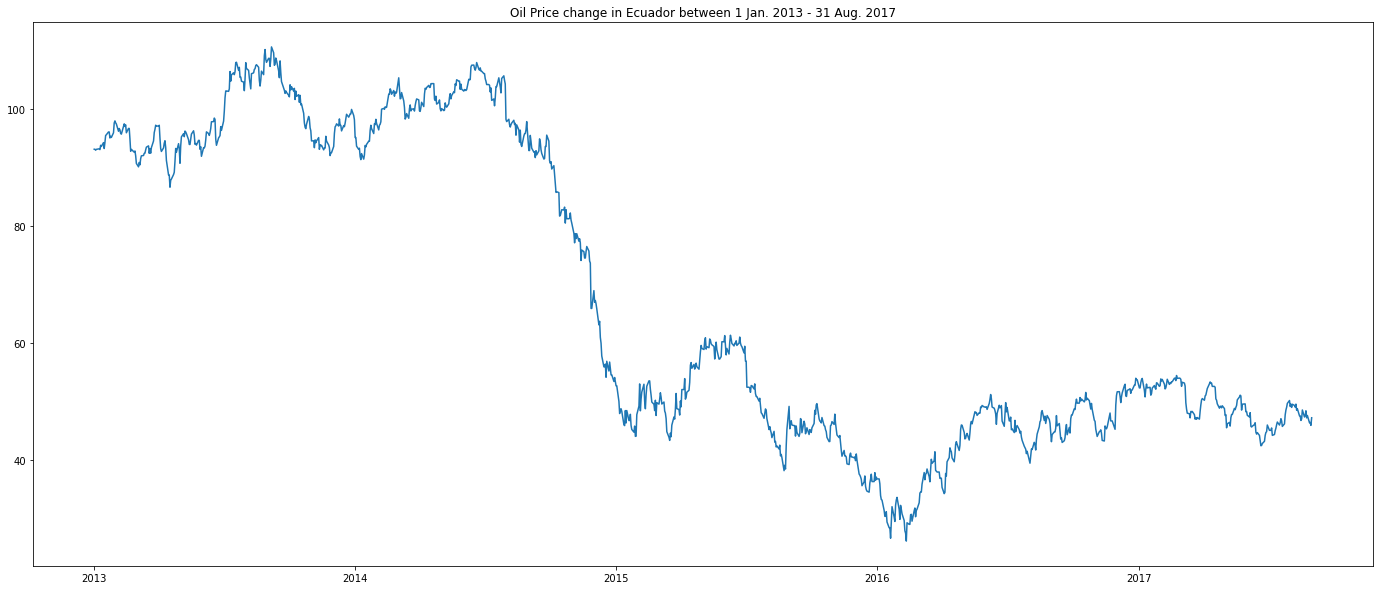

In [18]:
plt.figure(figsize = (24,10))
plt.title('Oil Price change in Ecuador between 1 Jan. 2013 - 31 Aug. 2017')
plt.plot(oil['date'], oil['dcoilwtico'])
plt.show()

## Plot in logarithmic scale

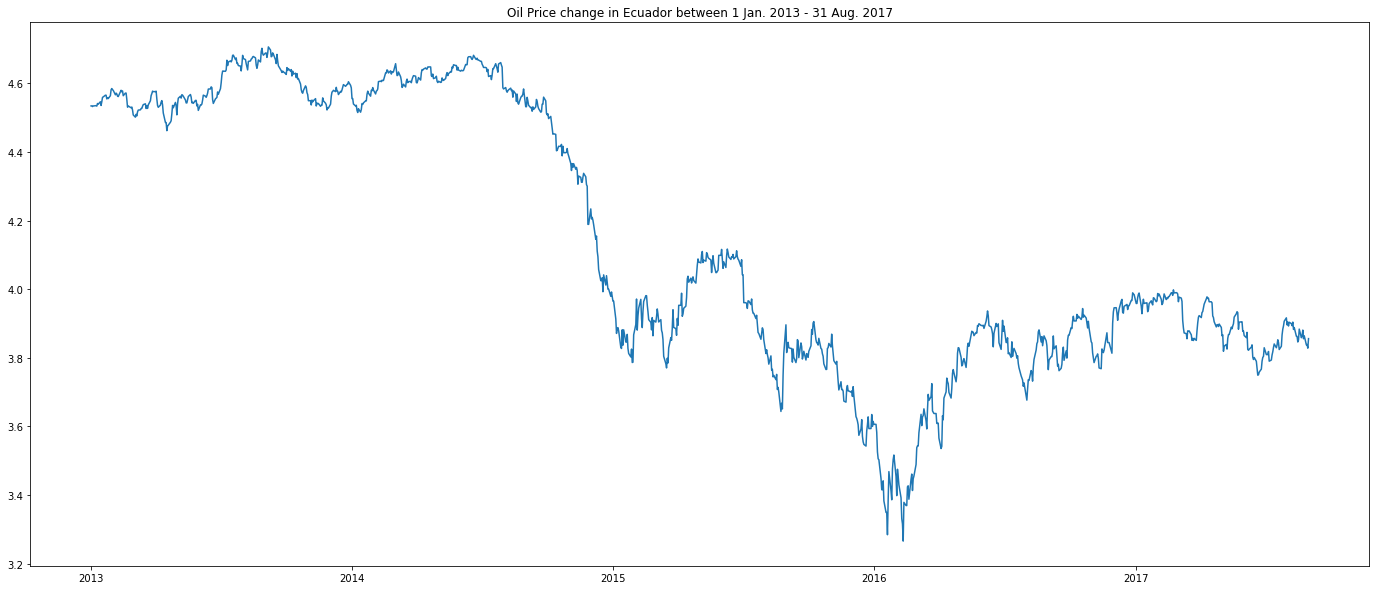

In [19]:
plt.figure(figsize = (24,10))
plt.title('Oil Price change in Ecuador between 1 Jan. 2013 - 31 Aug. 2017')
plt.plot(oil['date'], np.log(oil['dcoilwtico']))
plt.show()

## Relation between oil price and transaction count

In [20]:
transactions['date'] = pd.to_datetime(transactions['date'])

In [21]:
transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [22]:
total_transactions = transactions.groupby(by = 'date').sum('transactions')

In [23]:
total_transactions

,store_nbr,transactions
date,,
2013-01-01,25,770
2013-01-02,1210,93215
2013-01-03,1210,78504
2013-01-04,1210,78494
2013-01-05,1210,93573
...,...,...
2017-08-11,1485,89551
2017-08-12,1485,89927
2017-08-13,1485,85993


In [24]:
total_transactions

,store_nbr,transactions
date,,
2013-01-01,25,770
2013-01-02,1210,93215
2013-01-03,1210,78504
2013-01-04,1210,78494
2013-01-05,1210,93573
...,...,...
2017-08-11,1485,89551
2017-08-12,1485,89927
2017-08-13,1485,85993


In [25]:
oil_transaction_merged = oil.merge(total_transactions, how = 'inner', on = 'date')
oil_transaction_merged

,date,dcoilwtico,store_nbr,transactions
0,2013-01-01,93.14,25,770
1,2013-01-02,93.14,1210,93215
2,2013-01-03,92.97,1210,78504
3,2013-01-04,93.12,1210,78494
4,2013-01-07,93.20,1210,75597
...,...,...,...,...
1197,2017-08-09,49.59,1485,85452
1198,2017-08-10,48.54,1485,83064
1199,2017-08-11,48.81,1485,89551
1200,2017-08-14,47.59,1485,85448


<AxesSubplot:xlabel='transactions'>

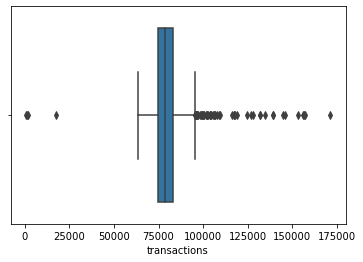

In [26]:
sns.boxplot(oil_transaction_merged['transactions'])

In [27]:
np.where(oil_transaction_merged['transactions'] < 25000)

(array([  0, 260, 520, 780], dtype=int64),)

In [28]:
oil_transaction_merged = oil_transaction_merged.drop([oil_transaction_merged.index[0], oil_transaction_merged.index[260], oil_transaction_merged.index[520]])

In [29]:
oil_transaction_merged = oil_transaction_merged.drop('store_nbr', axis = 1)

In [30]:
oil_transaction_merged

,date,dcoilwtico,transactions
1,2013-01-02,93.14,93215
2,2013-01-03,92.97,78504
3,2013-01-04,93.12,78494
4,2013-01-07,93.20,75597
5,2013-01-08,93.21,72325
...,...,...,...
1197,2017-08-09,49.59,85452
1198,2017-08-10,48.54,83064
1199,2017-08-11,48.81,89551
1200,2017-08-14,47.59,85448


In [31]:
corr = oil_transaction_merged.corr()

<AxesSubplot:>

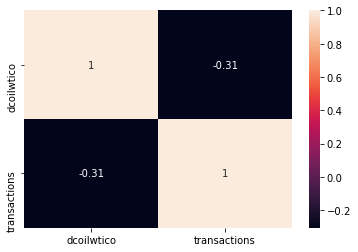

In [32]:
sns.heatmap(corr, annot = True)

The heatmap above shows the correlation between daiy oil prices and the number of total transactions. It indicates that there is a weak negative linear relationship  between oil prices and total transactions.

<AxesSubplot:>

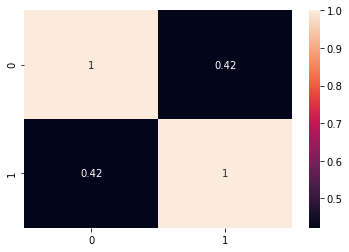

In [33]:
sns.heatmap(np.corrcoef(total_transactions['store_nbr'], total_transactions['transactions']), annot = True)

In `total_transactions` DataFrame, `store_nbr` column represents the sum of all store codes, which starts from 1 and goes until the number of total stores. However, in some dates, especially the first day od the year not all stores are open. That is why there are some low peak points. Also, there are some new branches of the store in years which also affect the values in the `store_nbr` column.

Although there are new stores opened, there is a relatively strong correlation between total transactions and number of stores.

## Plotting of Transactions 

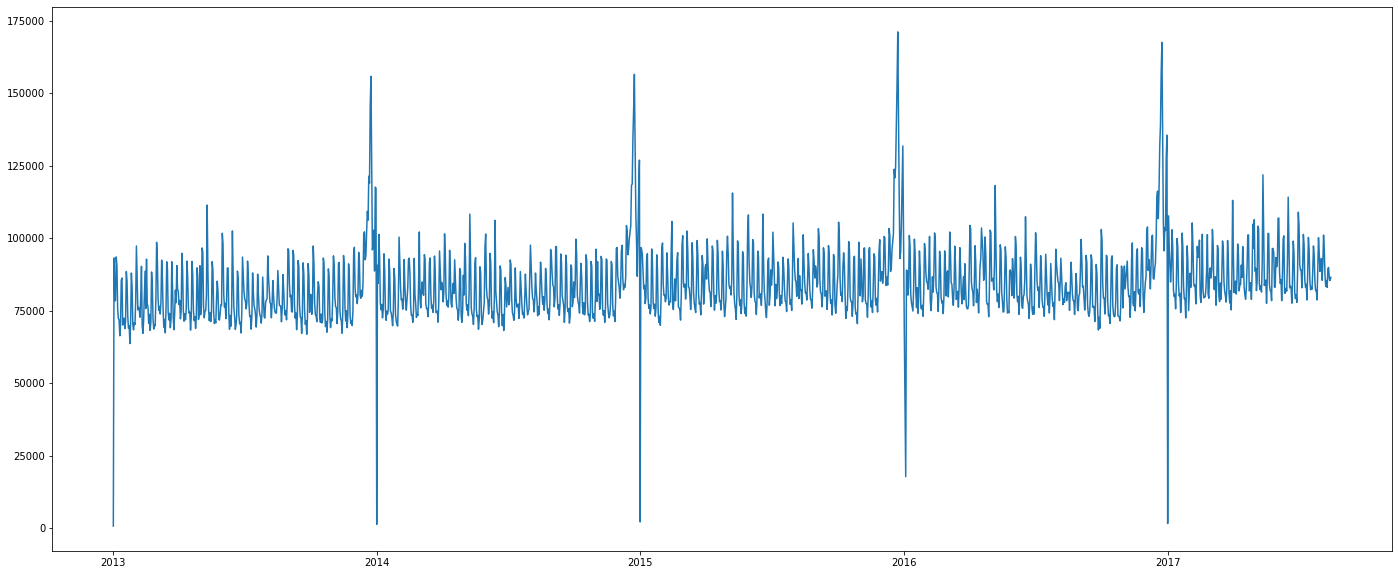

In [34]:
plt.figure(figsize = (24,10))
plt.plot(total_transactions.index, total_transactions['transactions'])
plt.show()

As we can see, there are big falls in every year. That is the firsy day of the year. Also, again almost every year a peak-week is observed. That can be explained by christmas.

## Holidays & sales

In [35]:
holidays

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [36]:
np.unique(holidays['type'])

array(['Additional', 'Bridge', 'Event', 'Holiday', 'Transfer', 'Work Day'],
      dtype=object)

In [37]:
total_transactions

,store_nbr,transactions
date,,
2013-01-01,25,770
2013-01-02,1210,93215
2013-01-03,1210,78504
2013-01-04,1210,78494
2013-01-05,1210,93573
...,...,...
2017-08-11,1485,89551
2017-08-12,1485,89927
2017-08-13,1485,85993


## Hierarchical Clustering of Stores
It is based on the total amount of transactions and it gave us 5 clusters.

In [38]:
total = transactions.groupby('store_nbr').sum('transactions')
total

,transactions
store_nbr,
1,2553963
2,3219901
3,5366350
4,2519007
5,2347877
6,3065896
7,2995993
8,4637971
9,3516162


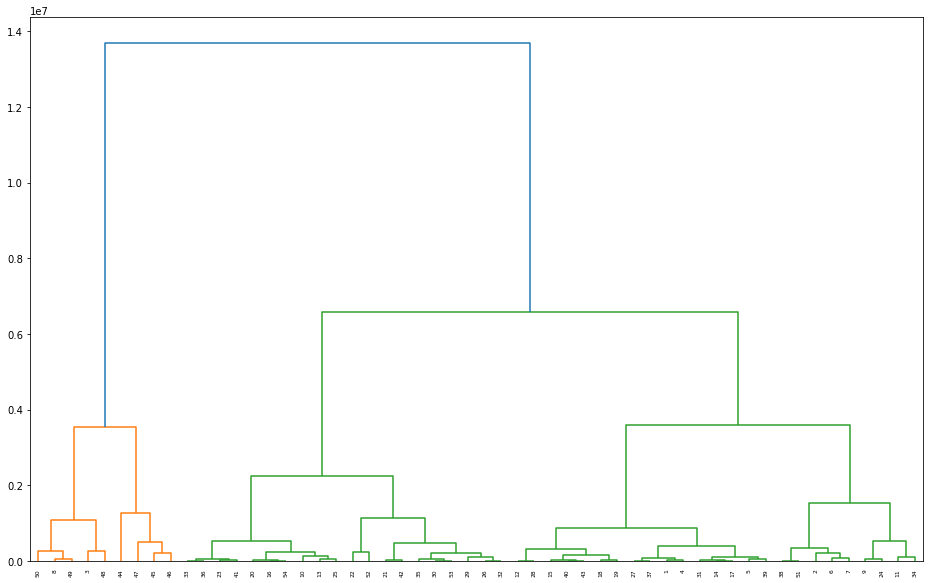

In [39]:
plt.figure(figsize=(16,10))
den = hc.dendrogram(hc.linkage(total, method='ward'), orientation='top',labels=total.index.to_numpy())

## Stores with most sales

This DataFrame is sorted version of the total number of transactions in each store in descending order. So, we are able to see the store with the most sales. Store `44` is the most popular store between these dates in terms of transactions. Although, number of transactions do not directly tell something about the revenue, there is a strong sign that store `44` might be have the most income between this time interval.

In [40]:
store_total = total.sort_values('transactions', ascending = False)
store_total

,transactions
store_nbr,
44,7273093
47,6535810
45,6201115
46,5990113
3,5366350
48,5107785
8,4637971
49,4574103
50,4384444


## Cities with most Transactions

In [41]:
stores[stores['city'] == 'Quito']

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15
16,17,Quito,Pichincha,C,12


In [42]:
all_cities = stores['city'].unique()

In [43]:
def cities(city):
    l = []
    for i in stores[stores['city'] == city]['store_nbr']:
        l.append(i)
    return l

In [44]:
city = {}
for i in all_cities:
    city[str(i)] = cities(i) 

In [45]:
city

{'Quito': [1, 2, 3, 4, 6, 7, 8, 9, 10, 17, 18, 20, 44, 45, 46, 47, 48, 49],
 'Santo Domingo': [5, 16, 21],
 'Cayambe': [11],
 'Latacunga': [12, 13],
 'Riobamba': [14],
 'Ibarra': [15],
 'Guaranda': [19],
 'Puyo': [22],
 'Ambato': [23, 50],
 'Guayaquil': [24, 26, 28, 29, 30, 32, 34, 51],
 'Salinas': [25],
 'Daule': [27],
 'Babahoyo': [31],
 'Quevedo': [33],
 'Playas': [35],
 'Libertad': [36],
 'Cuenca': [37, 39, 42],
 'Loja': [38],
 'Machala': [40, 41],
 'Esmeraldas': [43],
 'Manta': [52, 53],
 'El Carmen': [54]}

In [46]:
def city_total(state):
    count= 0
    for i in city[state]:
        count += float(total[total.index == i]['transactions'])
    return count

In [47]:
total_sales_city = {}
for i in all_cities:
    total_sales_city[str(i)] = city_total(i) 

In [48]:
total_sales_city 

{'Quito': 70999057.0,
 'Santo Domingo': 4655266.0,
 'Cayambe': 3972488.0,
 'Latacunga': 3531356.0,
 'Riobamba': 2287850.0,
 'Ibarra': 2209898.0,
 'Guaranda': 2107489.0,
 'Puyo': 504156.0,
 'Ambato': 6172615.0,
 'Guayaquil': 16546295.0,
 'Salinas': 1520362.0,
 'Daule': 2485687.0,
 'Babahoyo': 2306044.0,
 'Quevedo': 1743003.0,
 'Playas': 1123889.0,
 'Libertad': 1738129.0,
 'Cuenca': 5673847.0,
 'Loja': 2867052.0,
 'Machala': 3945341.0,
 'Esmeraldas': 2182356.0,
 'Manta': 1455475.0,
 'El Carmen': 1451290.0}

In [49]:
city_dict = {k: v for k, v in sorted(total_sales_city.items(), key=lambda item: item[1], reverse = True)}
city_dict

{'Quito': 70999057.0,
 'Guayaquil': 16546295.0,
 'Ambato': 6172615.0,
 'Cuenca': 5673847.0,
 'Santo Domingo': 4655266.0,
 'Cayambe': 3972488.0,
 'Machala': 3945341.0,
 'Latacunga': 3531356.0,
 'Loja': 2867052.0,
 'Daule': 2485687.0,
 'Babahoyo': 2306044.0,
 'Riobamba': 2287850.0,
 'Ibarra': 2209898.0,
 'Esmeraldas': 2182356.0,
 'Guaranda': 2107489.0,
 'Quevedo': 1743003.0,
 'Libertad': 1738129.0,
 'Salinas': 1520362.0,
 'Manta': 1455475.0,
 'El Carmen': 1451290.0,
 'Playas': 1123889.0,
 'Puyo': 504156.0}

In [50]:
city_sales_df = pd.DataFrame()
city_sales_df['Cities'] = city_dict.keys()
city_sales_df['Transactions'] = city_dict.values()
city_sales_df

,Cities,Transactions
0,Quito,70999057.0
1,Guayaquil,16546295.0
2,Ambato,6172615.0
3,Cuenca,5673847.0
4,Santo Domingo,4655266.0
5,Cayambe,3972488.0
6,Machala,3945341.0
7,Latacunga,3531356.0
8,Loja,2867052.0
9,Daule,2485687.0


## Modelling

In modeling phase, we used different algorithms and commapred the predictions. We used `Linear Regression`, `XGBoost`, and `Random Forest`. 

Here, we saw different characteristics of different algorithms. For example, `xgBoost` algorithm is able to predict unseen values in the training set. It predicted negative values for sales which never exists in the `train` DataFrame.

First of all, we tried linear regression because the number of features in our train set was low and our estimation problem was not complex. Then, we wanted to use one bagging and one boosting algorithm which are Random Forest and XGBoost.

In [51]:
import numpy as np
import pandas as pd
import yfinance as yf

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RNN

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [52]:
deneme=train
deneme['date']=pd.to_datetime(deneme['date'])

In [53]:
deneme.set_index('date',inplace=True)

In [54]:
deneme['day']=deneme.index.day
deneme['dayofweek']=deneme.index.dayofweek
deneme['week']=deneme.index.weekofyear

In [55]:
def is_weekend(ds):
    date = pd.to_datetime(ds)
    if date.dayofweek > 4:
        return 1
    else:
        return 0

In [56]:
deneme=deneme.reset_index()
deneme['weekend'] = deneme['date'].apply(is_weekend)

In [57]:
deneme['date']=pd.to_datetime(deneme['date'])

In [58]:
deneme.set_index('date',inplace=True)

In [59]:
train = deneme

In [60]:
train.head()

,id,store_nbr,family,sales,onpromotion,day,dayofweek,week,weekend
date,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,1,1,1,0
2013-01-01,1,1,BABY CARE,0.0,0,1,1,1,0
2013-01-01,2,1,BEAUTY,0.0,0,1,1,1,0
2013-01-01,3,1,BEVERAGES,0.0,0,1,1,1,0
2013-01-01,4,1,BOOKS,0.0,0,1,1,1,0


In [61]:
dummy = test
dummy['date']=pd.to_datetime(dummy['date'])
dummy.set_index('date',inplace=True)
dummy['day']=dummy.index.day
dummy['dayofweek']=dummy.index.dayofweek
dummy['week']=dummy.index.weekofyear

In [62]:
dummy = dummy.reset_index()
dummy['weekend'] = dummy['date'].apply(is_weekend)
dummy['date']=pd.to_datetime(dummy['date'])
dummy.set_index('date',inplace=True)

In [63]:
test.head()

,id,store_nbr,family,onpromotion,day,dayofweek,week
date,,,,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0,16,2,33
2017-08-16,3000889,1,BABY CARE,0,16,2,33
2017-08-16,3000890,1,BEAUTY,2,16,2,33
2017-08-16,3000891,1,BEVERAGES,20,16,2,33
2017-08-16,3000892,1,BOOKS,0,16,2,33


In [64]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(train[['family']])

OrdinalEncoder()

In [65]:
train['family'] = enc.transform(train[['family']])

In [66]:
enc = OrdinalEncoder()
enc.fit(test[['family']])
test['family'] = enc.transform(test[['family']])

In [67]:
train.head()

,id,store_nbr,family,sales,onpromotion,day,dayofweek,week,weekend
date,,,,,,,,,
2013-01-01,0,1,0.0,0.0,0,1,1,1,0
2013-01-01,1,1,1.0,0.0,0,1,1,1,0
2013-01-01,2,1,2.0,0.0,0,1,1,1,0
2013-01-01,3,1,3.0,0.0,0,1,1,1,0
2013-01-01,4,1,4.0,0.0,0,1,1,1,0


In [68]:
test.head()

,id,store_nbr,family,onpromotion,day,dayofweek,week
date,,,,,,,
2017-08-16,3000888,1,0.0,0,16,2,33
2017-08-16,3000889,1,1.0,0,16,2,33
2017-08-16,3000890,1,2.0,2,16,2,33
2017-08-16,3000891,1,3.0,20,16,2,33
2017-08-16,3000892,1,4.0,0,16,2,33


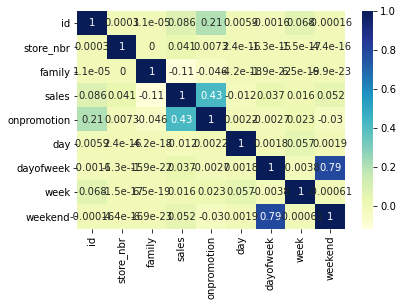

In [69]:
dataplot = sns.heatmap(train.corr(), cmap="YlGnBu", annot=True)
plt.show()

There is a high positive correlation between **"dayofweek"** and **"weekend"** columns. So we drop **"dayofweek"* column to increase the success of our linear regression model.

In [70]:
train=train.drop("dayofweek",axis=1)
test=test.drop("dayofweek",axis=1)

In [71]:
X_train = train[['id', 'store_nbr', 'onpromotion','day','week','family']]
Y_train = train[['sales']]
X_test = test[['id', 'store_nbr', 'onpromotion','day','week','family']]

# Linear Regression with cross-validation

In [72]:
import statsmodels.api as sm
from urllib.request import urlopen
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [74]:
reg = LinearRegression()

In [75]:
folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
scores = cross_val_score(reg, X_train, Y_train, scoring='r2', cv=folds)
scores   

array([0.19136794, 0.19520056, 0.18677268, 0.19007403, 0.19419916,
       0.19501962, 0.2000355 , 0.18849857, 0.19819855, 0.19816365])

In [102]:
reg = LinearRegression().fit(X_train, Y_train)

In [103]:
reg.coef_

array([[-2.59081305e-06,  2.69462376e+00,  3.82016158e+01,
        -1.65932498e+00,  5.67631577e-01, -1.09640796e+01]])

In [104]:
reg.intercept_

array([375.16288492])

In [105]:
y_pred_reg = reg.predict(X_test)

In [106]:
y_pred_reg

array([[362.26541119],
       [351.30132899],
       [416.74047845],
       ...,
       [ 69.27315583],
       [363.92200027],
       [  9.1433756 ]])

In [107]:
float(y_pred_reg[0].round(2))

362.27

In [108]:
for i in range(len(y_pred_reg)):
    y_pred_reg[i] = float(y_pred_reg[i].round(2))

In [109]:
y_pred_reg

array([[362.27],
       [351.3 ],
       [416.74],
       ...,
       [ 69.27],
       [363.92],
       [  9.14]])

# XGBoost

In [110]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [78]:
model = XGBRegressor()
model.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [85]:
yhat = model.predict(X_test)

In [87]:
pred_xgb = yhat

In [88]:
pred_xgb

array([ -23.803482,  -26.145634, -123.65843 , ..., 1447.9039  ,
         56.884384,  -27.787342], dtype=float32)

# Random Forest

In [113]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor(n_estimators=20)
rfr.fit(X_train, Y_train)

In [53]:
y_pred = rfr.predict(X_test)

In [54]:
y_pred = y_pred.reshape(-1,1)

In [55]:
pred_rf = pd.DataFrame()
pred_rf = X_test
pred_rf['Sales Predictions'] = y_pred.round(2)

In [57]:
pred_rf

,id,store_nbr,onpromotion,day,week,family,Sales Predictions
date,,,,,,,
2017-08-16,3000888,1,0,16,33,0.0,2.60
2017-08-16,3000889,1,0,16,33,1.0,0.00
2017-08-16,3000890,1,2,16,33,2.0,8.25
2017-08-16,3000891,1,20,16,33,3.0,2111.35
2017-08-16,3000892,1,0,16,33,4.0,0.05
...,...,...,...,...,...,...,...
2017-08-31,3029395,9,1,31,35,28.0,506.48
2017-08-31,3029396,9,0,31,35,29.0,82.07
2017-08-31,3029397,9,1,31,35,30.0,1407.26


In [58]:
pred_reg = [item for sublist in y_pred_reg for item in sublist]
pred_reg

[362.27,
 351.3,
 416.74,
 1093.41,
 318.41,
 765.86,
 296.48,
 1240.56,
 1993.63,
 951.22,
 290.83,
 279.86,
 2675.6,
 219.73,
 208.77,
 274.21,
 416.05,
 175.88,
 546.93,
 153.95,
 754.21,
 323.03,
 464.87,
 110.09,
 99.13,
 775.79,
 77.2,
 66.24,
 55.27,
 44.31,
 9812.96,
 557.2,
 11.41,
 386.52,
 375.55,
 440.99,
 1996.29,
 342.66,
 904.72,
 320.73,
 1455.82,
 4348.18,
 975.47,
 315.08,
 304.11,
 3922.3,
 243.98,
 233.02,
 298.46,
 440.3,
 200.13,
 762.19,
 178.2,
 778.46,
 347.28,
 527.32,
 134.34,
 123.38,
 838.25,
 101.45,
 90.49,
 79.52,
 68.56,
 8843.97,
 581.45,
 35.67,
 389.21,
 378.25,
 443.69,
 2342.8,
 345.36,
 945.62,
 323.43,
 1649.52,
 5840.73,
 978.16,
 317.77,
 306.81,
 4154.21,
 246.68,
 235.71,
 377.56,
 443.0,
 202.82,
 726.68,
 180.89,
 781.16,
 273.57,
 453.61,
 137.04,
 126.07,
 802.74,
 104.15,
 131.38,
 82.22,
 71.25,
 6287.15,
 584.15,
 38.36,
 391.91,
 380.94,
 446.38,
 1810.68,
 348.05,
 986.51,
 326.12,
 1423.0,
 4697.38,
 980.86,
 320.47,
 309.5,
 3583.8

# Comparison of Predictions

In [127]:
pred_all = pd.DataFrame()
pred_all['Linear Regression'] = pred_reg
pred_all['Random Forest'] = list(pred_rf['Sales Predictions'])
pred_all['XgBoost'] = pred_xgb

In [128]:
pred_all

,Linear Regression,Random Forest,XgBoost
0,341.47,3.15,-23.803482
1,330.51,0.00,-26.145634
2,395.97,7.05,-123.658432
3,1072.78,2166.00,2505.997803
4,297.62,0.00,-38.493160
...,...,...,...
28507,91.27,324.59,358.395477
28508,42.10,87.60,12.933407
28509,69.34,1273.91,1447.903931
28510,364.06,125.70,56.884384


In [137]:
pred_all['id'] = test['id'].reset_index(drop=True)

In [139]:
pred_all = pred_all[['id', 'Linear Regression', 'Random Forest', 'XgBoost']]
pred_all

,id,Linear Regression,Random Forest,XgBoost
0,3000888,341.47,3.15,-23.803482
1,3000889,330.51,0.00,-26.145634
2,3000890,395.97,7.05,-123.658432
3,3000891,1072.78,2166.00,2505.997803
4,3000892,297.62,0.00,-38.493160
...,...,...,...,...
28507,3029395,91.27,324.59,358.395477
28508,3029396,42.10,87.60,12.933407
28509,3029397,69.34,1273.91,1447.903931
28510,3029398,364.06,125.70,56.884384


# Failing in LSTM

Unlike other artificial neural networks models, LSTM stores historical values in its memory and this information is carried throughout the cells. So it makes sense to use LSTM on data that has correlations with historical values such as time series.

In [129]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(8,1)))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(1, activation = 'relu'))

model.compile(loss='mape', optimizer='adam', metrics = ['mse'])

In [130]:
model.fit(X_train,Y_train,epochs=1,verbose=1)

93778/93778 [==============================] - 849s 9ms/step - loss: 95.4055 - mse: 1342399.3750


In [131]:
Y_pred = model.predict(X_test)

891/891 [==============================] - 4s 4ms/step


In [134]:
np.unique(Y_pred)

array([0.], dtype=float32)